In [1]:
import numpy as np 
import geopandas as gpd 
import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
import pandas as pd 
from shapely.geometry import shape 
# from shapely.geometry import Polygon 
import json 
from shapely import wkt 
from shapely.geometry import Point
from shapely.geometry import box
from math import cos, radians
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.cm import ScalarMappable
import seaborn as sns 
import contextily as ctx
import rioxarray as rxr
import xarray as xr
import matplotlib.patches as mpatches
from windrose import WindroseAxes 

In [2]:
# import easysnowdata

In [3]:
!pip install censusdata


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [4]:
from matplotlib import cm
from sklearn.preprocessing import MinMaxScaler
import matplotlib as mpl
import censusdata
from rasterstats import zonal_stats

## Social Vulnerability Index 

* CDC/ATSDR Social Vulnerability Index
* The degree to which a community exhibits certain social conditions, including high poverty, low percentage of vehicle access, or
crowded households, among others 

#### 4 Themes 
* Socioeconomic Status - RPL_THEME1
* Household Characteristics - RPL_THEME2
* Racial & Ethnic Minority Status - RPL_THEME3
* Housing Type & Transportation - RPL_THEME4 

#### Overall Vulnerability Ranking available as well 
* overall summary ranking variable is RPL_THEMES 

#### The higher the value, the greater the vulnerability 

Documentation can be found here: https://svi.cdc.gov/map25/data/docs/SVI2022Documentation_ZCTA.pdf

In [5]:
svi_cali_census_tracts_fp = 'California_SVI_Census_Tracts.csv'

In [6]:
svi_cali_census_tracts_df = pd.read_csv(svi_cali_census_tracts_fp)

### Filter out LA County & relevant columns (population, 4 SVI themes, population) 

In [7]:
la_svi_census_df = svi_cali_census_tracts_df[svi_cali_census_tracts_df['COUNTY'] == 'Los Angeles County'].reset_index()

In [8]:
# la_svi_census_df.columns.tolist()

In [9]:
la_svi_census_df = la_svi_census_df[['COUNTY', 'FIPS', 'LOCATION', 'AREA_SQMI','E_DISABL', 'E_AGE17', 'E_AGE65', 'RPL_THEME1', 'RPL_THEME2', 'RPL_THEME3', 'RPL_THEME4', 'RPL_THEMES']]

#### Filter out No Data Values 

In [10]:
la_svi_census_df = la_svi_census_df[~(la_svi_census_df['RPL_THEME1'] == -999)]

In [11]:
# la_svi_census_df.head()

### Shapefiles of LA Census Tracts 

Data source: https://redistricting.lacounty.gov/mapping-files-data-download/ 

In [12]:
la_census_gdf = gpd.read_file('tl_2020_06_tract_LACounty.shp')

In [13]:
la_census_gdf['GEOID'] = la_census_gdf['GEOID'].astype(int)
la_census_gdf = la_census_gdf.rename(columns = {'GEOID':'FIPS'})

#### Filter out relevant columns 

In [14]:
la_census_gdf = la_census_gdf[['TRACTCE', 'FIPS', 'NAMELSAD', 'geometry']]

In [15]:
la_census_gdf.head()

TRACTCE        FIPS              NAMELSAD  \
0  262601  6037262601  Census Tract 2626.01   
1  300100  6037300100     Census Tract 3001   
2  300501  6037300501  Census Tract 3005.01   
3  310701  6037310701  Census Tract 3107.01   
4  300200  6037300200     Census Tract 3002   

                                            geometry  
0  POLYGON ((-118.57556 34.08019, -118.57497 34.0...  
1  POLYGON ((-118.2486 34.23881, -118.24858 34.23...  
2  POLYGON ((-118.24875 34.22249, -118.24875 34.2...  
3  POLYGON ((-118.31952 34.18495, -118.31915 34.1...  
4  POLYGON ((-118.24864 34.23324, -118.24863 34.2...

In [16]:
# la_census_gdf.crs

#### Combine LA Census Tract Gdf & Social Vulnerability Index Data 

In [17]:
merged_df = la_census_gdf.merge(la_svi_census_df, on='FIPS', how='left')  

In [18]:
merged_df.columns

Index(['TRACTCE', 'FIPS', 'NAMELSAD', 'geometry', 'COUNTY', 'LOCATION',
       'AREA_SQMI', 'E_DISABL', 'E_AGE17', 'E_AGE65', 'RPL_THEME1',
       'RPL_THEME2', 'RPL_THEME3', 'RPL_THEME4', 'RPL_THEMES'],
      dtype='object')

In [19]:
merged_df.head()

TRACTCE        FIPS              NAMELSAD  \
0  262601  6037262601  Census Tract 2626.01   
1  300100  6037300100     Census Tract 3001   
2  300501  6037300501  Census Tract 3005.01   
3  310701  6037310701  Census Tract 3107.01   
4  300200  6037300200     Census Tract 3002   

                                            geometry              COUNTY  \
0  POLYGON ((-118.57556 34.08019, -118.57497 34.0...  Los Angeles County   
1  POLYGON ((-118.2486 34.23881, -118.24858 34.23...  Los Angeles County   
2  POLYGON ((-118.24875 34.22249, -118.24875 34.2...  Los Angeles County   
3  POLYGON ((-118.31952 34.18495, -118.31915 34.1...  Los Angeles County   
4  POLYGON ((-118.24864 34.23324, -118.24863 34.2...  Los Angeles County   

                                            LOCATION  AREA_SQMI  E_DISABL  \
0  Census Tract 2626.01; Los Angeles County; Cali...   1.397825     135.0   
1  Census Tract 3001; Los Angeles County; California   1.772726    1004.0   
2  Census Tract 3005.01; Los Angeles County; Cali...   0.486587     340.0   
3  Census Tract 3107.01; Los Angeles County; Cali...   0.198973     745.0   
4  Census Tract 3002; Los Angeles County; California   0.750577     388.0   

   E_AGE17  E_AGE65  RPL_THEME1  RPL_THEME2  RPL_THEME3  RPL_THEME4  \
0    850.0    780.0      0.0157      0.1756      0.1147      0.1798   
1   1791.0   1396.0      0.1202      0.6954      0.3303      0.0461   
2    598.0    408.0      0.3837      0.5165      0.3783      0.3389   
3    345.0    759.0      0.7527      0.9799      0.1847      0.8449   
4   1160.0   1059.0      0.2250      0.2607      0.3394      0.3347   

   RPL_THEMES  
0      0.0454  
1      0.1428  
2      0.3841  
3      0.8577  
4      0.2405

In [20]:
# merged_df['RPL_THEMES'].describe()

#### Reproject to EPSG:32611 -- UTM Zone 11N 

In [21]:
merged_df = merged_df.set_crs('EPSG:4326')
merged_df = merged_df.to_crs('EPSG: 32611')

#### Filter out 'coastal tracts' 

In [22]:
## Use GPS coordinates (from Google Maps) & use a spatial join to filter them out 

point_1 = Point(-118.555579, 34.014150)
gdf_point_1 = gpd.GeoDataFrame([{'geometry': point_1}], crs="EPSG:4326")
gdf_point_1 = gdf_point_1.to_crs('EPSG: 32611')

point_2 = Point(-118.685579, 34.014150)
gdf_point_2 = gpd.GeoDataFrame([{'geometry': point_2}], crs="EPSG:4326")
gdf_point_2 = gdf_point_2.to_crs('EPSG: 32611')

In [23]:
gdf_4 = gpd.sjoin(merged_df, gdf_point_1, how = 'inner', predicate = 'contains')
gdf_5 = gpd.sjoin(merged_df, gdf_point_2, how = 'inner', predicate = 'contains')

gdfs = pd.concat([gdf_4, gdf_5])

In [24]:
merged_df = merged_df[~(merged_df['TRACTCE'].isin(gdfs['TRACTCE'].unique()))]

### Find tracts around Palisade Area 

In [25]:
### Using city in Palisades Area 

point_palisades = Point(-118.546757, 34.044841)
gdf_palisades_point = gpd.GeoDataFrame([{'geometry': point_palisades}], crs="EPSG:4326")
gdf_palisades_point = gdf_palisades_point.to_crs('EPSG: 32611')


### Specify Buffer 

gdf_palisades_point['geometry'] = gdf_palisades_point.geometry.buffer(3e3)
filtered_pali_gdf = gpd.sjoin(merged_df, gdf_palisades_point, how = 'inner', predicate = 'intersects')

In [26]:
merged_df_palisades = merged_df[(merged_df['TRACTCE'].isin(filtered_pali_gdf['TRACTCE'].unique()))]

### Find tracts around Eaton Area  

In [27]:
point_eaton = Point(-118.095058, 34.177908)
gdf_eaton_point = gpd.GeoDataFrame([{'geometry': point_eaton}], crs="EPSG:4326")
gdf_eaton_point = gdf_eaton_point.to_crs('EPSG: 32611')

## Specify Buffer 

gdf_eaton_point['geometry'] = gdf_eaton_point.geometry.buffer(1e3)
filtered_eaton_gdf = gpd.sjoin(merged_df, gdf_eaton_point, how = 'inner', predicate = 'intersects')

In [28]:
merged_df_eaton = merged_df[(merged_df['TRACTCE'].isin(filtered_eaton_gdf['TRACTCE'].unique()))]

### Fire Perimeter Bounds 

In [29]:
# fire_perimeter_fp = '../Data/fires_perimeter.geojson'

In [30]:
fire_perimeter_fp = '/Users/kwamedonkor/Downloads/UW/2nd Year/CEWA Project/KayDee_Folder/Data/fires_perimeter.geojson'

In [31]:
fire_perimeter_gdf = gpd.read_file(fire_perimeter_fp)
fire_perimeter_gdf

mission_group  OBJECTID                              GlobalID  \
0         Eaton      1269  ea6b6983-73b6-49fa-b467-1081579fb284   
1     Palisades      1264  0bc1ddb3-63bf-4fd8-a01b-d522f57e4083   

             type source        poly_DateCurrent                mission  \
0  Heat Perimeter  FIRIS 2025-01-09 02:29:10.844      CA-LAC-EATON-N57B   
1  Heat Perimeter  FIRIS 2025-01-07 23:17:39.000  CA-LFD-PALISADES-N57B   

  incident_name                       incident_number    area_acres  ...  \
0         Eaton  72660adc-b5ef-4d96-a33f-b4ea3740a4e3  10589.956010  ...   
1     Palisades                                         1261.520779  ...   

  PercentPerimToBeContained ModifiedBySystem2 sourceoid  \
0                      None              None      None   
1                      None              None      None   

                              websiteId websiteDbId  \
0  dbfa574e-1b10-4467-b5e5-7d1c06ebc8dc        4319   
1  abfed7a3-794a-4294-9852-43176dcbc18a        4318   

                            dataverseId displayStatus Shape__Area  \
0  2b91dbc1-79cd-ef11-b8e9-001dd804aa64      Inactive    0.004192   
1  f0a2f70e-2dcd-ef11-b8e9-001dd804aa64        Active    0.000499   

  Shape__Length                                           geometry  
0      0.818015  MULTIPOLYGON (((-118.15647 34.18125, -118.1564...  
1      0.342099  MULTIPOLYGON (((-118.56728 34.04256, -118.5672...  

[2 rows x 36 columns]

In [32]:
fire_perimeter_gdf = fire_perimeter_gdf.to_crs(merged_df_palisades.crs)

### Plot of Palisades & Eaton Areas showing Perimeter of Wildfires  

In [33]:
# fig, ax = plt.subplots(figsize = (10,8))

# # plot all la census tracts 
# merged_df.plot(ax = ax, edgecolor = 'white', lw = 0.6, facecolor = 'grey', legend = True, legend_kwds = {'label':'SVI Score'})

# # Palisades Area 
# merged_df_palisades.plot(ax = ax, facecolor = 'orange', edgecolor = 'white')

# # Eaton Area 
# merged_df_eaton.plot(ax = ax, facecolor = 'blue', edgecolor = 'white')

# # Fire Perimeter Plots 
# fire_perimeter_gdf.plot(ax = ax, facecolor = 'red', alpha = 0.6)

# # Set Axis Limits 
# ax.set_xlim(340000,416000)
# ax.set_ylim(3.755e6,3.80e6)

# ax.set_title('A selection of the Census Tracts affected the Wildfires ', fontsize = 16)

# plt.show()

### Align merged_df & fire perimeter  

In [34]:
def shift_north(gdf, meters):
    gdf = gdf.copy()
    gdf['geometry'] = gdf.translate(yoff=meters)
    return gdf

In [35]:
merged_df = shift_north(merged_df, 470)

### Fire Spread & Various Demographics 

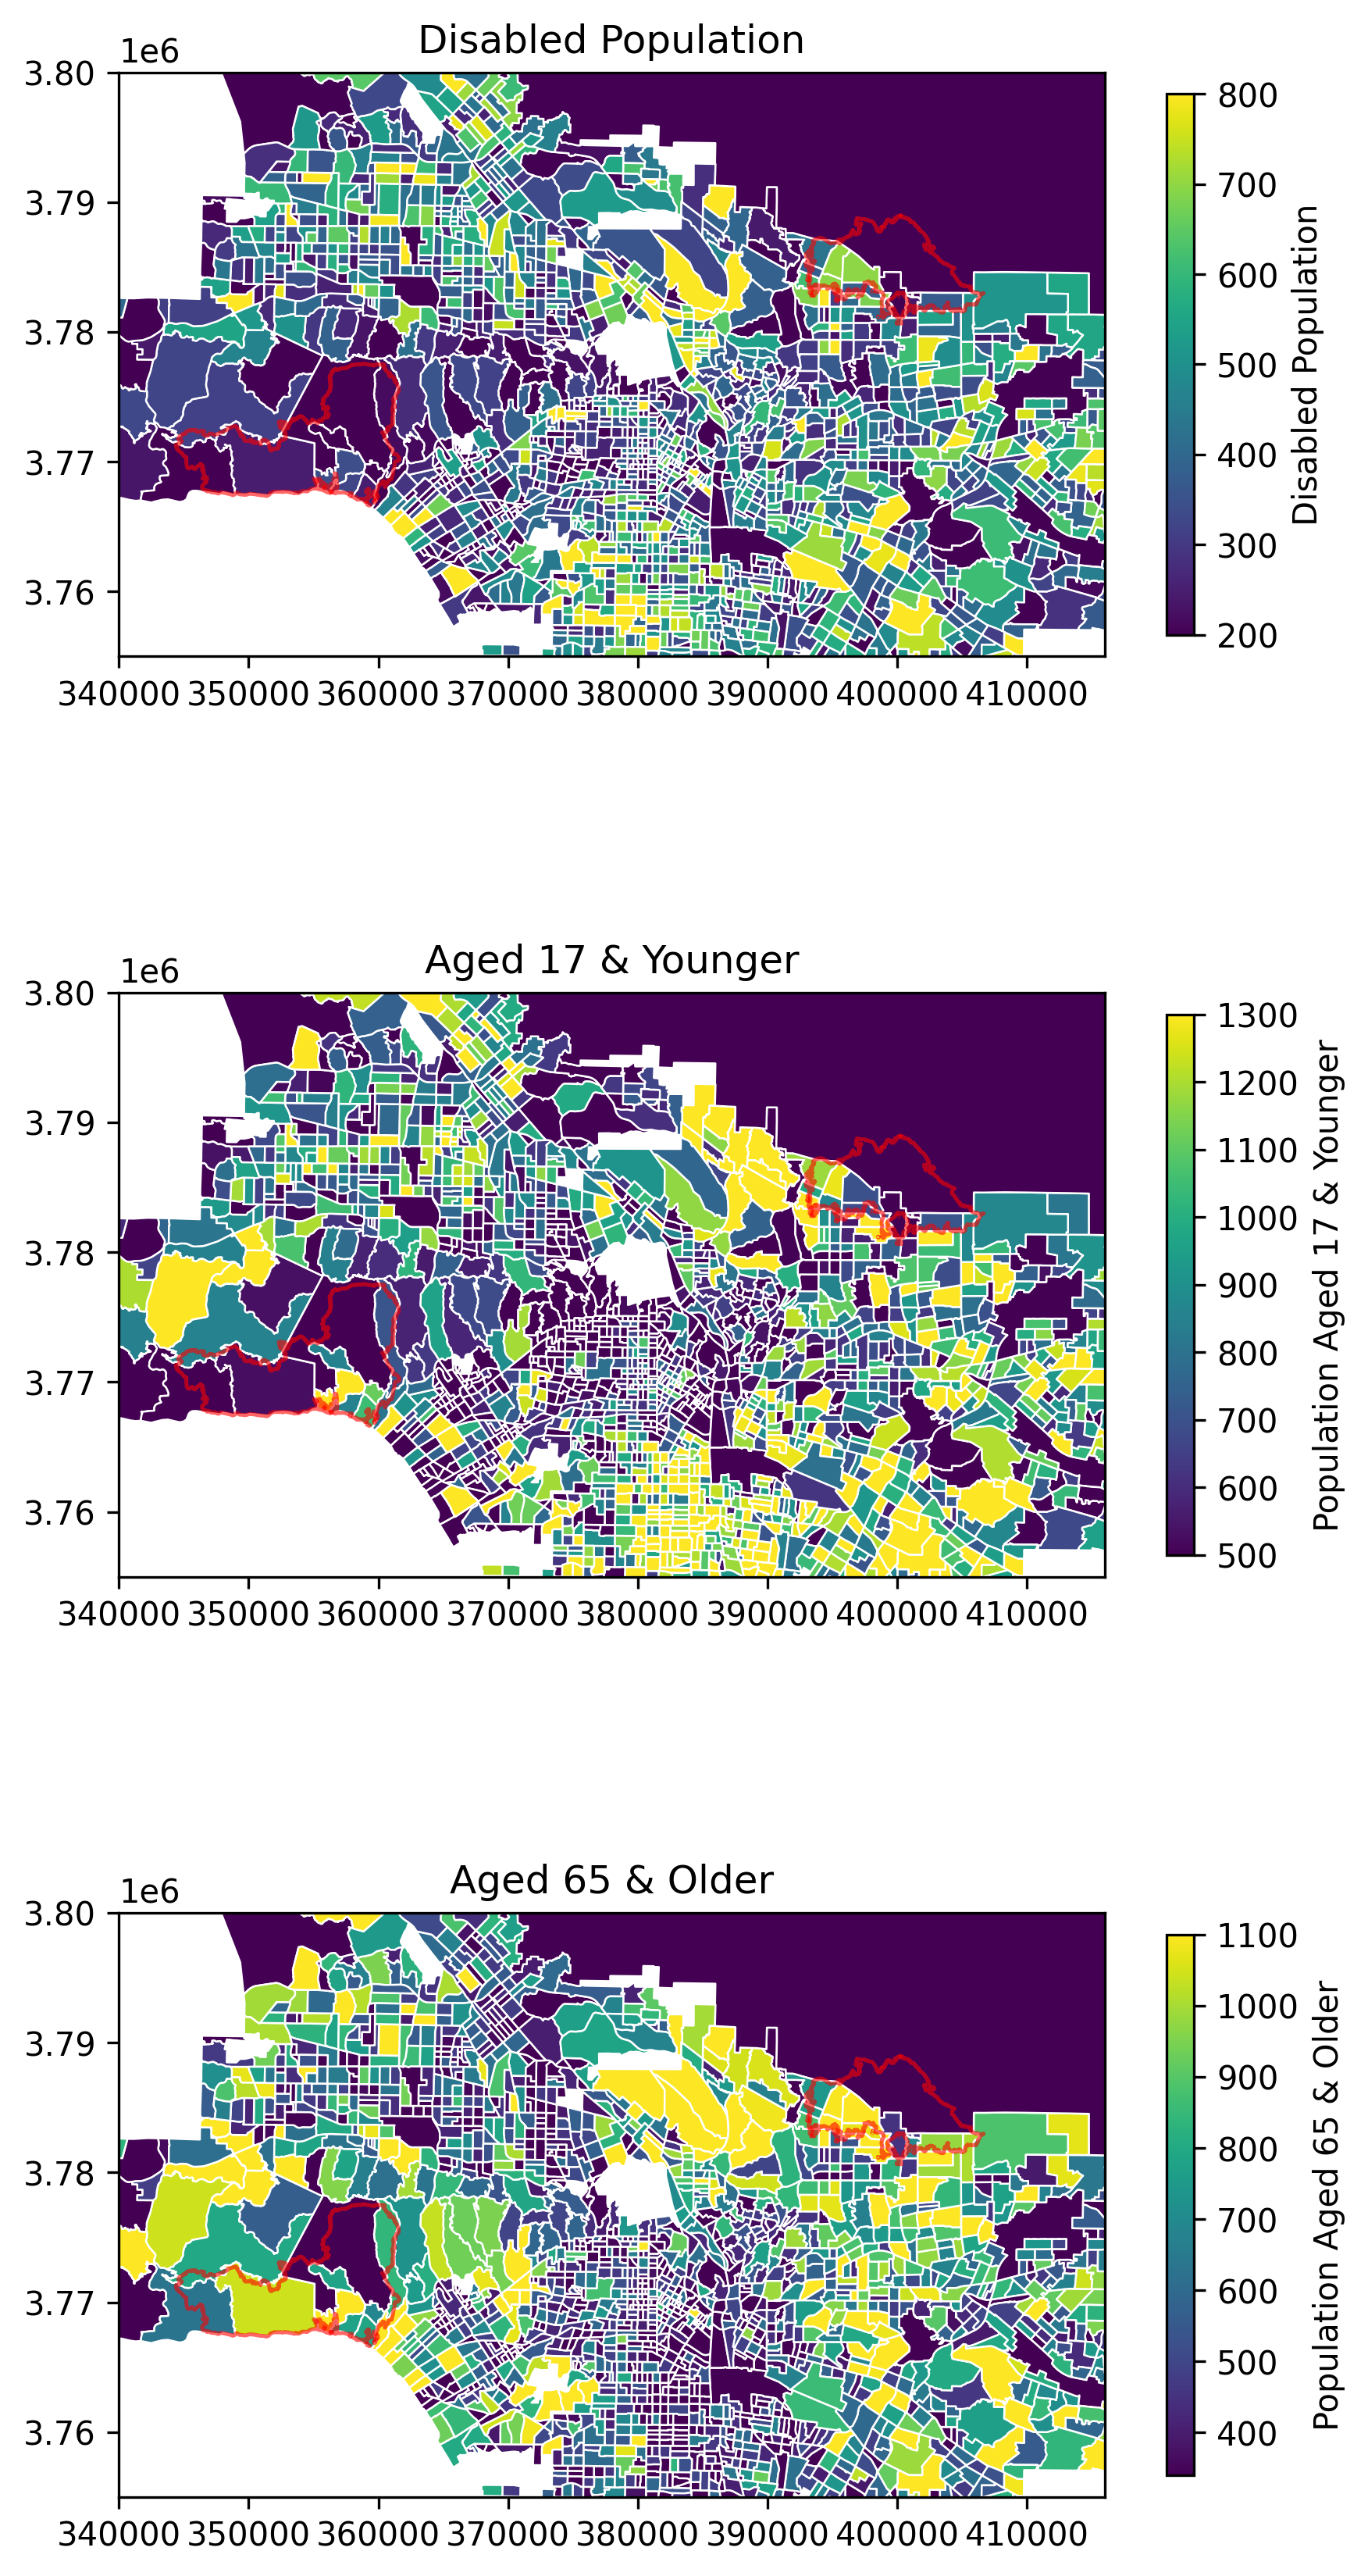

In [36]:
fig, axs = plt.subplots(ncols=1, nrows=3, figsize=(6, 12), dpi=300)

categories = ['E_DISABL', 'E_AGE17', 'E_AGE65']
titles = [
    'Disabled Population',
    'Aged 17 & Younger',
    'Aged 65 & Older',
]
colorbars = [
    'Disabled Population',
    'Population Aged 17 & Younger',
    'Population Aged 65 & Older'
]
vmin_vals = [200, 500, 340] 
vmax_vals = [800, 1300, 1100] 

for i, cat in enumerate(categories):
    merged_df.plot(column=cat, ax=axs[i], edgecolor='white', lw=0.6, facecolor='grey',
                   legend=True, cmap='viridis', vmin=vmin_vals[i], vmax=vmax_vals[i],
                   legend_kwds={'label': colorbars[i], 'shrink': 0.6})
    
    # Fire Perimeter Plot
    fire_perimeter_gdf.plot(ax=axs[i], facecolor='none', edgecolor = 'red', lw = 1.2, alpha=0.6)

    axs[i].set_xlim(340000, 416000)
    axs[i].set_ylim(3.755e6, 3.80e6)

    axs[i].set_title(titles[i], fontsize=12)

plt.tight_layout()
plt.show()


### Fire Spread & Vulnerability Themes 

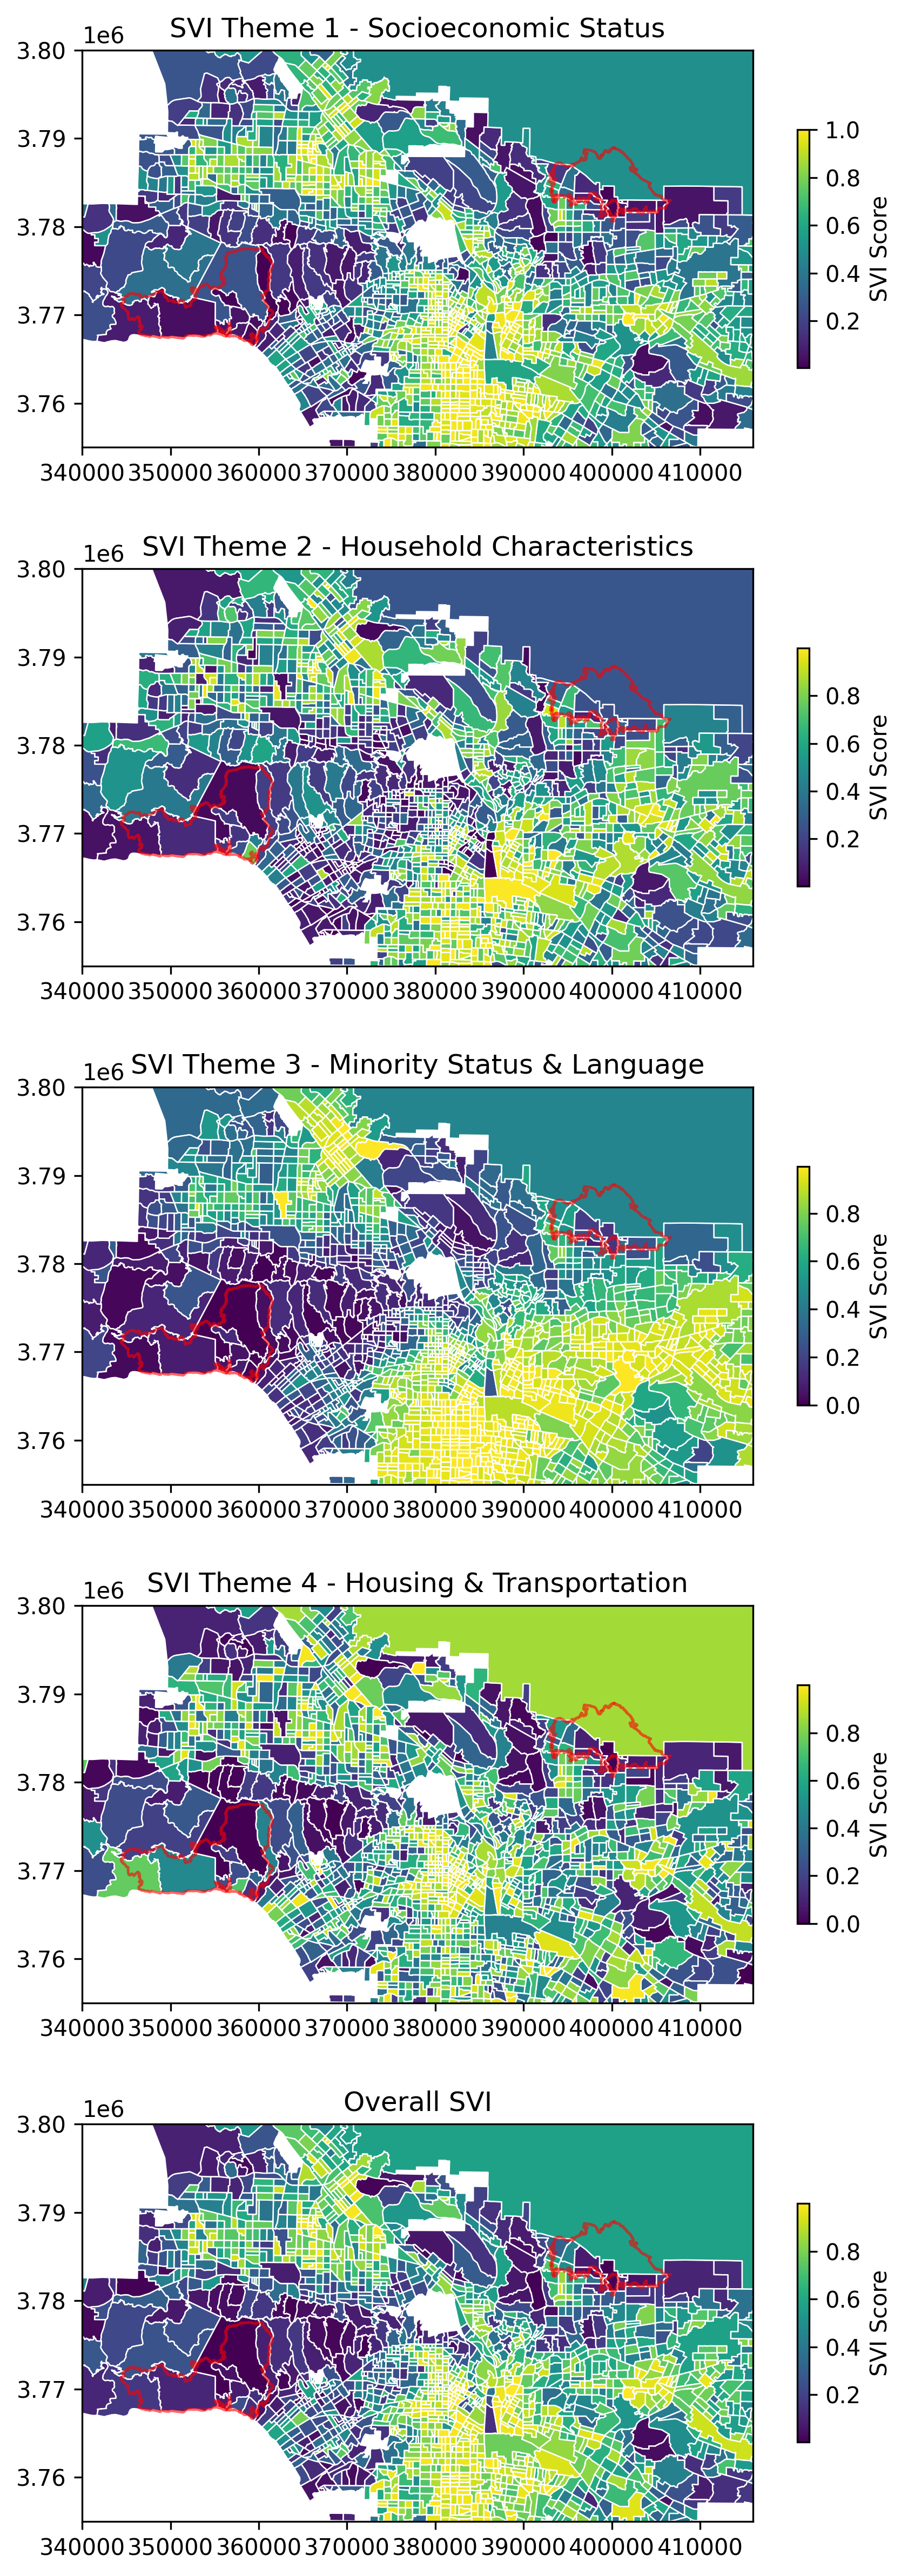

In [37]:

fig, axs = plt.subplots(ncols=1, nrows=5, figsize=(6, 16), dpi=300)

themes = ['RPL_THEME1', 'RPL_THEME2', 'RPL_THEME3', 'RPL_THEME4', 'RPL_THEMES']
titles = [
    'SVI Theme 1 - Socioeconomic Status',
    'SVI Theme 2 - Household Characteristics',
    'SVI Theme 3 - Minority Status & Language',
    'SVI Theme 4 - Housing & Transportation',
    'Overall SVI'
]

for i, theme in enumerate(themes):

    merged_df.plot(column=theme, ax=axs[i], edgecolor='white', lw=0.6, facecolor='grey',
                   legend=True, legend_kwds={'label': 'SVI Score', 'shrink': 0.6})
    
    # Fire Perimeter Plot
    # fire_perimeter_gdf.plot(ax=axs[i], facecolor='red', alpha=0.6)
    fire_perimeter_gdf.plot(ax=axs[i], facecolor='none', edgecolor = 'red', lw = 1.2, alpha=0.6)


    axs[i].set_xlim(340000, 416000)
    axs[i].set_ylim(3.755e6, 3.80e6)

    axs[i].set_title(titles[i], fontsize=12)

plt.tight_layout()
plt.show()


In [38]:
merged_df.describe()

FIPS    AREA_SQMI     E_DISABL      E_AGE17      E_AGE65  \
count  2.496000e+03  2467.000000  2467.000000  2467.000000  2467.000000   
mean   6.037403e+09     1.585942   423.250507   848.228618   573.797730   
std    2.306432e+05    15.238061   210.696864   433.178913   308.352989   
min    6.037101e+09     0.017727     0.000000     0.000000     0.000000   
25%    6.037209e+09     0.210112   272.000000   537.500000   348.000000   
50%    6.037403e+09     0.363446   393.000000   810.000000   515.000000   
75%    6.037552e+09     0.640747   543.000000  1115.500000   748.500000   
max    6.037990e+09   575.174927  1655.000000  3247.000000  2037.000000   

        RPL_THEME1   RPL_THEME2   RPL_THEME3   RPL_THEME4   RPL_THEMES  
count  2467.000000  2467.000000  2467.000000  2467.000000  2467.000000  
mean      0.596946     0.520611     0.628960     0.548976     0.583711  
std       0.282211     0.290183     0.292731     0.285062     0.289089  
min       0.002500     0.000300     0.000000     0.000000     0.001500  
25%       0.368850     0.274500     0.384700     0.311000     0.348850  
50%       0.635500     0.538900     0.700100     0.572500     0.634600  
75%       0.848400     0.780800     0.894000     0.798050     0.833200  
max       1.000000     0.999800     0.994700     0.999900     0.999800

### Read in World_Pop File 

In [39]:
world_pop_fp = 'la_pop_100_clipped_raster.tif'

In [40]:
world_pop_da = rxr.open_rasterio(world_pop_fp, masked = True).squeeze()

In [41]:
def print_raster_info(da):
    """
    Prints metadata information about a raster dataset.

    Parameters:
    da (xarray.DataArray): The raster dataset opened with rioxarray.
    """
    print(f"""Raster shape: {da.rio.shape}
Raster height: {da.rio.height}
Raster width: {da.rio.width}
Raster nodata value: {da.rio.nodata}
Raster encoded nodata value: {da.rio.encoded_nodata}
Raster number of bands: {da.rio.count}
Raster CRS: {da.rio.crs}
Raster resolution: {da.rio.resolution()}
Raster extent: {da.rio.bounds()}
Raster transform: 
{da.rio.transform()}""")

In [42]:
print_raster_info(world_pop_da)

Raster shape: (1211, 1232)
Raster height: 1211
Raster width: 1232
Raster nodata value: nan
Raster encoded nodata value: -99999.0
Raster number of bands: 1
Raster CRS: EPSG:32611
Raster resolution: (83.53136553457226, -83.53136553457237)
Raster extent: (332756.0260332632, 3706867.64066913, 435666.66837185615, 3808024.1243314967)
Raster transform: 
| 83.53, 0.00, 332756.03|
| 0.00,-83.53, 3808024.12|
| 0.00, 0.00, 1.00|


#### Zonal Stats (Fire Perimeters) 

In [43]:
stats_fire_pop = zonal_stats(fire_perimeter_gdf, world_pop_fp, stats=["sum"], raster_out=False)

In [44]:
fire_pop_df = pd.DataFrame(stats_fire_pop).rename(columns={"sum":"pop_affected"})

In [45]:
fire_pop_df['Area'] = ['Eaton', 'Palisades']

In [46]:
fire_pop_df = fire_pop_df[['Area', 'pop_affected']]

In [47]:
fire_pop_df

Area  pop_affected
0      Eaton  24530.894531
1  Palisades  24676.228516

#### Surprisingly close in terms of population though the areas are vastly different 
* Investigate this 
* Suggests that part of Eaton might be more densely populated (though, smaller area)
* Or most of the affected Palisades area was forest 

* https://www.nbcnews.com/news/us-news/california-wildfires-what-we-know-palisades-eaton-los-angeles-rcna188239

* https://www.worldvision.org/disaster-relief-news-stories/california-fires-facts-faqs-how-to-help

* https://www.hcn.org/articles/with-so-many-displaced-by-fires-los-angeles-county-cant-accurately-measure-homelessness/

#### Zonal Stats (Total_Pop) per Census Tract 

In [48]:
# clip census tract using lat & lon

In [49]:
clipped_census = merged_df.copy()
clipped_census = clipped_census[['TRACTCE', 'geometry']]

##### Filtering Close-up of Study Area 

In [50]:
# or tract ID = 930400 

In [51]:
clipped_census = clipped_census[(clipped_census['geometry'].centroid.y > 3.762e6) & (clipped_census['geometry'].centroid.y < 3.790e6) & (clipped_census['geometry'].centroid.x > 340000) & (clipped_census['geometry'].centroid.x < 416000) | (clipped_census['TRACTCE'] == '930400') ]

In [52]:
clipped_census = clipped_census.reset_index(drop = True)

In [53]:
clipped_census

TRACTCE                                           geometry
0     262601  POLYGON ((354630.815 3772637.727, 354687.553 3...
1     300501  POLYGON ((384978.528 3788001.24, 384978.83 378...
2     310701  POLYGON ((378406.008 3783919.624, 378440.01 37...
3     300200  POLYGON ((385003.365 3789192.98, 385005.215 37...
4     310100  POLYGON ((376458.424 3786337.848, 376463.399 3...
...      ...                                                ...
1285  192700  POLYGON ((380826.563 3772647.009, 380936.823 3...
1286  194500  POLYGON ((372780.108 3771953.777, 372794.642 3...
1287  195100  POLYGON ((382209.251 3773987.92, 382219.169 37...
1288  195300  POLYGON ((380846.526 3774664.394, 381048 37746...
1289  137501  POLYGON ((353596.75 3782215.613, 353607.335 37...

[1290 rows x 2 columns]

<Axes: >

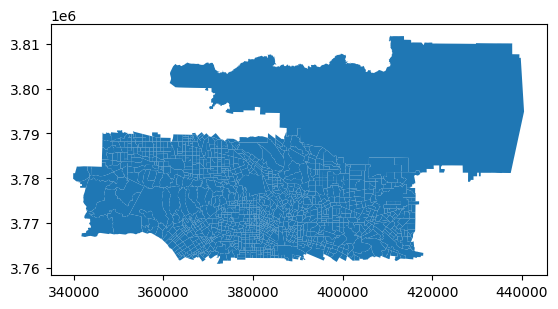

In [54]:
clipped_census.plot()

#### Find Total_Pop per census tract

In [55]:
stats_tract_pop = zonal_stats(clipped_census, world_pop_fp, stats=["sum"], raster_out=False)
tract_pop_df = pd.DataFrame(stats_tract_pop).rename(columns={"sum":"total_pop_tract"})

In [56]:
clipped_census = clipped_census.join(tract_pop_df)

In [57]:
clipped_census

TRACTCE                                           geometry  \
0     262601  POLYGON ((354630.815 3772637.727, 354687.553 3...   
1     300501  POLYGON ((384978.528 3788001.24, 384978.83 378...   
2     310701  POLYGON ((378406.008 3783919.624, 378440.01 37...   
3     300200  POLYGON ((385003.365 3789192.98, 385005.215 37...   
4     310100  POLYGON ((376458.424 3786337.848, 376463.399 3...   
...      ...                                                ...   
1285  192700  POLYGON ((380826.563 3772647.009, 380936.823 3...   
1286  194500  POLYGON ((372780.108 3771953.777, 372794.642 3...   
1287  195100  POLYGON ((382209.251 3773987.92, 382219.169 37...   
1288  195300  POLYGON ((380846.526 3774664.394, 381048 37746...   
1289  137501  POLYGON ((353596.75 3782215.613, 353607.335 37...   

      total_pop_tract  
0         2491.999268  
1         4049.434082  
2         1461.388428  
3         5300.053711  
4         2911.986816  
...               ...  
1285      6102.615234  
1286      3977.085449  
1287      6017.867188  
1288      3308.205078  
1289      4517.426758  

[1290 rows x 3 columns]

#### Save clipped_census 

In [58]:
# clipped_census.to_file("clipped_census.geojson", driver="GeoJSON")

#### Find census tracts that intersect with fire perimeter (Area of Interest) 

In [59]:
fire_perim_copy = fire_perimeter_gdf.copy()

In [60]:
fire_perim_copy = fire_perim_copy[['mission_group', 'geometry']]

In [61]:
fire_perim_copy

mission_group                                           geometry
0         Eaton  MULTIPOLYGON (((393427.168 3782856.873, 393426...
1     Palisades  MULTIPOLYGON (((355330.406 3767982.4, 355330.5...

In [62]:
filt_tract_fire_intersect = gpd.sjoin(clipped_census, fire_perim_copy, how = 'inner', predicate = 'intersects').reset_index(drop=True)

#### Find the intersections (fire perimeter & census tracts) 
* How much of each census tract was directly affected
* And calculated this population for each tract 

In [63]:
tracts_within_fire_perim = gpd.overlay(filt_tract_fire_intersect, fire_perim_copy, how='intersection')

In [64]:
tracts_within_fire_perim = tracts_within_fire_perim[['TRACTCE', 'total_pop_tract', 'mission_group_1', 'geometry']]

In [65]:
# tracts_within_fire_perim

In [66]:
# ghjvbknkln

In [67]:
stats_tract_intersect_pop = zonal_stats(tracts_within_fire_perim, world_pop_fp, stats=["sum"], raster_out=False)
intersecting_tract_pop_df = pd.DataFrame(stats_tract_intersect_pop).rename(columns={"sum":"intersecting_pop_tract"})

In [68]:
# intersecting_tract_pop_df

In [69]:
tracts_within_fire_perim = tracts_within_fire_perim.join(intersecting_tract_pop_df)
tracts_within_fire_perim = tracts_within_fire_perim[['TRACTCE', 'intersecting_pop_tract', 'total_pop_tract', 'mission_group_1', 'geometry']]
tracts_within_fire_perim = tracts_within_fire_perim.fillna(0)

In [70]:
# tracts_within_fire_perim

#### Filter out the tracts with 0 population values 
* So that it's left with ACTUAL tracts that were affected 

In [71]:
tracts_within_fire_perim = tracts_within_fire_perim[tracts_within_fire_perim['intersecting_pop_tract'] != 0].reset_index(drop = True)

In [72]:
tracts_within_fire_perim['percent_affected'] = tracts_within_fire_perim['intersecting_pop_tract'] / tracts_within_fire_perim['total_pop_tract']
tracts_within_fire_perim = tracts_within_fire_perim[['TRACTCE', 'percent_affected', 'intersecting_pop_tract', 'total_pop_tract', 'mission_group_1', 'geometry']]

In [73]:
tracts_within_fire_perim

TRACTCE  percent_affected  intersecting_pop_tract  total_pop_tract  \
0   262601          1.000000             2491.999268      2491.999268   
1   262704          0.938972             5298.451660      5642.819824   
2   262706          0.869916             5000.015625      5747.699219   
3   262501          1.000000             1690.234131      1690.234131   
4   262400          0.124518              345.488495      2774.605713   
5   800504          0.456786             1430.972656      3132.698975   
6   800506          0.878223             2572.715332      2929.455322   
7   800104          0.028684               91.880577      3203.152832   
8   980019          0.930199             1283.863037      1380.202393   
9   262604          0.880223             3357.692871      3814.591797   
10  262802          0.177693              715.363525      4025.841797   
11  262301          0.008409               26.982487      3208.589111   
12  430502          0.002518               17.045513      6769.169922   
13  460401          0.017640               16.795841       952.129761   
14  461502          0.002808               17.474386      6223.090820   
15  430301          0.010666               17.113617      1604.445557   
16  461300          0.108162              520.031982      4807.905273   
17  460002          0.241898              550.204529      2274.534912   
18  461100          0.858618             3589.793701      4180.897461   
19  460900          0.092974              703.452759      7566.095215   
20  461000          0.427808             2575.455322      6020.114258   
21  461400          0.064605              195.884888      3032.059082   
22  461501          0.196235              618.521301      3151.937988   
23  461200          0.571840             2383.512207      4168.142578   
24  930400          0.000660                1.754627      2657.261719   
25  460001          0.159733              233.815292      1463.785645   
26  430501          0.341846              370.164246      1082.839966   
27  462900          0.003506               13.797214      3935.590332   
28  462500          0.088652              613.064209      6915.399414   
29  430400          0.033026              112.236206      3398.424805   
30  430600          0.001461                8.842849      6054.523438   
31  460200          1.000000             4380.744629      4380.745117   
32  460301          0.731243             1788.188721      2445.408447   
33  460302          0.656272             2409.513672      3671.518311   
34  460101          0.942332             3393.486816      3601.157715   

   mission_group_1                                           geometry  
0        Palisades  POLYGON ((354687.553 3772797.911, 354891.051 3...  
1        Palisades  MULTIPOLYGON (((356370.39 3767929.137, 356383....  
2        Palisades  MULTIPOLYGON (((358232.095 3767660.543, 358258...  
3        Palisades  POLYGON ((358876.515 3769240.134, 358879.347 3...  
4        Palisades  MULTIPOLYGON (((359689.783 3776724.789, 359711...  
5        Palisades  POLYGON ((344623.574 3771378.073, 344623.622 3...  
6        Palisades  MULTIPOLYGON (((347455.668 3771629.144, 347475...  
7        Palisades  MULTIPOLYGON (((352823.464 3772744.179, 352778...  
8        Palisades  POLYGON ((352778.205 3772659.253, 352823.464 3...  
9        Palisades  MULTIPOLYGON (((355550.363 3769297.087, 355626...  
10       Palisades  MULTIPOLYGON (((359838.866 3767083.2, 359833.4...  
11       Palisades  MULTIPOLYGON (((361295.294 3774922.877, 361290...  
12           Eaton  MULTIPOLYGON (((403184.984 3781617.675, 403325...  
13           Eaton  POLYGON ((393140.73 3785443.419, 393153.18 378...  
14           Eaton  MULTIPOLYGON (((394584.225 3783347.438, 394592...  
15           Eaton  MULTIPOLYGON (((405868.15 3782292.418, 405868....  
16           Eaton  MULTIPOLYGON (((395687.823 3782837.834, 395688...  
17           Eaton  POLYGON ((400586.905 3781435.406, 400592.32 37...  
18    

In [74]:
# merge this and the merged_df file 

In [75]:
merged_df_copy = merged_df.copy()

In [76]:
merged_df_copy = merged_df_copy.drop(columns = ['geometry'])

In [77]:
# merged_df_copy

In [78]:
filt_study_area = pd.merge(tracts_within_fire_perim, merged_df_copy, how = 'inner', on = 'TRACTCE')

#### Use % affected pop to estimate Weighted SVI 

In [79]:
cols_to_weight = ['E_DISABL', 'E_AGE17', 'E_AGE65', 'RPL_THEME1', 'RPL_THEME2', 'RPL_THEME3', 'RPL_THEME4', 'RPL_THEMES']  

for col in cols_to_weight:
    filt_study_area[f'weighted_{col}'] = filt_study_area[col] * filt_study_area['percent_affected']


In [80]:
filt_study_area

TRACTCE  percent_affected  intersecting_pop_tract  total_pop_tract  \
0   262601          1.000000             2491.999268      2491.999268   
1   262704          0.938972             5298.451660      5642.819824   
2   262706          0.869916             5000.015625      5747.699219   
3   262501          1.000000             1690.234131      1690.234131   
4   262400          0.124518              345.488495      2774.605713   
5   800504          0.456786             1430.972656      3132.698975   
6   800506          0.878223             2572.715332      2929.455322   
7   800104          0.028684               91.880577      3203.152832   
8   980019          0.930199             1283.863037      1380.202393   
9   262604          0.880223             3357.692871      3814.591797   
10  262802          0.177693              715.363525      4025.841797   
11  262301          0.008409               26.982487      3208.589111   
12  430502          0.002518               17.045513      6769.169922   
13  460401          0.017640               16.795841       952.129761   
14  461502          0.002808               17.474386      6223.090820   
15  430301          0.010666               17.113617      1604.445557   
16  461300          0.108162              520.031982      4807.905273   
17  460002          0.241898              550.204529      2274.534912   
18  461100          0.858618             3589.793701      4180.897461   
19  460900          0.092974              703.452759      7566.095215   
20  461000          0.427808             2575.455322      6020.114258   
21  461400          0.064605              195.884888      3032.059082   
22  461501          0.196235              618.521301      3151.937988   
23  461200          0.571840             2383.512207      4168.142578   
24  930400          0.000660                1.754627      2657.261719   
25  460001          0.159733              233.815292      1463.785645   
26  430501          0.341846              370.164246      1082.839966   
27  462900          0.003506               13.797214      3935.590332   
28  462500          0.088652              613.064209      6915.399414   
29  430400          0.033026              112.236206      3398.424805   
30  430600          0.001461                8.842849      6054.523438   
31  460200          1.000000             4380.744629      4380.745117   
32  460301          0.731243             1788.188721      2445.408447   
33  460302          0.656272             2409.513672      3671.518311   
34  460101          0.942332             3393.486816      3601.157715   

   mission_group_1                                           geometry  \
0        Palisades  POLYGON ((354687.553 3772797.911, 354891.051 3...   
1        Palisades  MULTIPOLYGON (((356370.39 3767929.137, 356383....   
2        Palisades  MULTIPOLYGON (((358232.095 3767660.543, 358258...   
3        Palisades  POLYGON ((358876.515 3769240.134, 358879.347 3...   
4        Palisades  MULTIPOLYGON (((359689.783 3776724.789, 359711...   
5        Palisades  POLYGON ((344623.574 3771378.073, 344623.622 3...   
6        Palisades  MULTIPOLYGON (((347455.668 3771629.144, 347475...   
7        Palisades  MULTIPOLYGON (((352823.464 3772744.179, 352778...   
8        Palisades  POLYGON ((352778.205 3772659.253, 352823.464 3...   
9        Palisades  MULTIPOLYGON (((355550.363 3769297.087, 355626...   
10       Palisades  MULTIPOLYGON (((359838.866 3767083.2, 359833.4...   
11       Palisades  MULTIPOLYGON (((361295.294 3774922.877, 361290...   
12           Eaton  MULTIPOLYGON (((403184.984 3781617.675, 403325...   
13           Eaton  POLYGON ((393140.73 3785443.419, 393153.18 378...   
14           Eaton  MULTIPOLYGON (((394584.225 3783347.438, 394592...   
15           Eaton  MULTIPOLYGON (((405868.15 3782292.418, 405868....   
16           Eaton  MULTIPOLYGON (((395687.823 3782837.834, 395688...   
17           Eaton  POLYGON ((400586.905 3781435.406, 400592

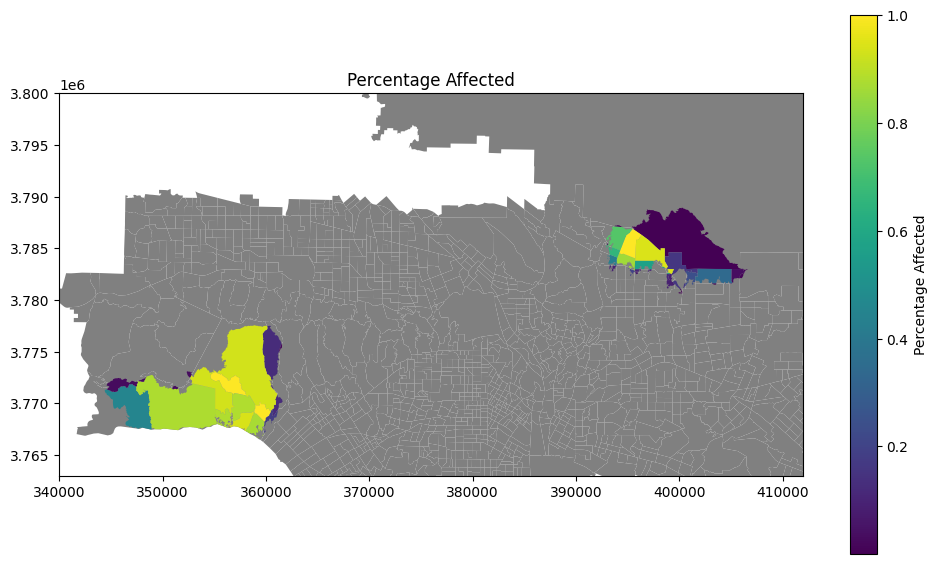

In [81]:
fig, ax = plt.subplots(figsize = (12,10))

# plot rest of tracts as grey 
clipped_census.plot(ax = ax, facecolor = 'grey')

# 
filt_study_area.plot(ax = ax, column = 'percent_affected', legend = True, legend_kwds = {'label':'Percentage Affected', 'shrink':0.7})

ax.set_title('Percentage Affected')

# Set Axis Limits 
ax.set_xlim(340000,412000)
ax.set_ylim(3.763e6,3.80e6)

plt.show()

In [82]:
# fig, ax = plt.subplots(figsize = (12,10))

# # plot rest of tracts as grey 
# clipped_census.plot(ax = ax, facecolor = 'grey')

# # 
# filt_study_area.plot(ax = ax, column = 'weighted_RPL_THEMES', legend = True, legend_kwds = {'label':'Vulnerability Score', 'shrink':0.7})

# ax.set_title('Weighted SVI')

# # Set Axis Limits 
# ax.set_xlim(340000,412000)
# ax.set_ylim(3.763e6,3.80e6)

# plt.show()

In [83]:
filt_study_area_palisades = filt_study_area[filt_study_area['mission_group_1'] == 'Palisades']

In [84]:
# filt_study_area_palisades

In [85]:
census_tract = filt_study_area_palisades['NAMELSAD'].values

percent_affected = (filt_study_area_palisades['percent_affected'].values) * 100

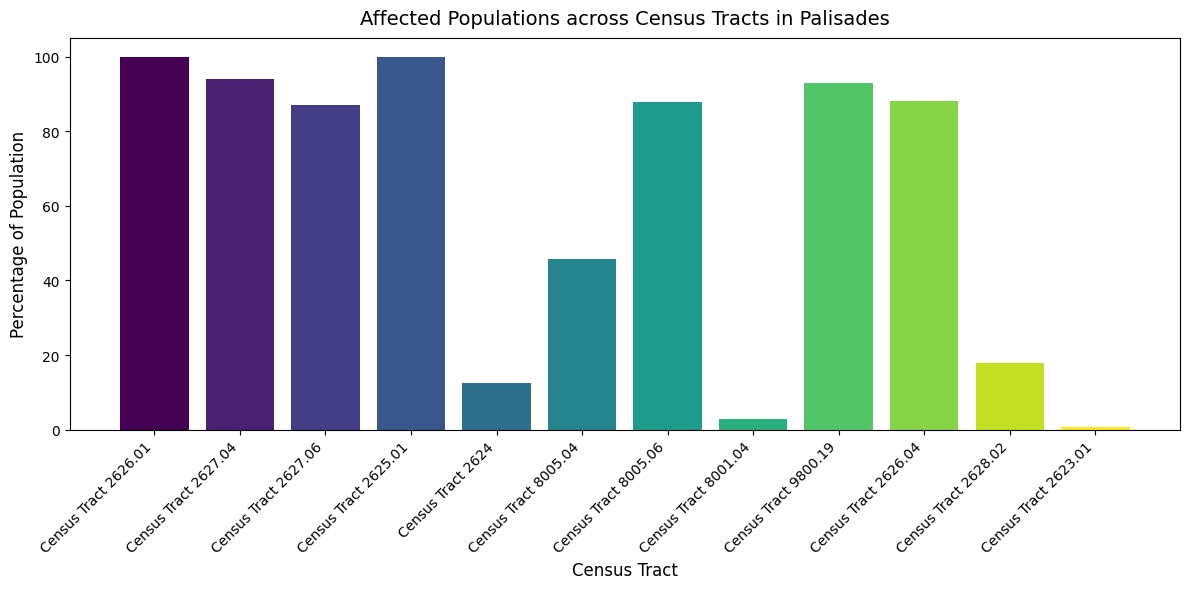

In [86]:
# Generate colors based on the number of census tracts
colors = plt.cm.viridis(np.linspace(0, 1, len(census_tract)))

fig, ax = plt.subplots(figsize=(12, 6))

# Create a bar plot with colors
ax.bar(census_tract, percent_affected, color=colors)

# ax.set_xticklabels(census_tract, rotation=45, ha="right", fontsize=10)
plt.xticks(rotation=45, ha="right", fontsize=10)  # This avoids the warning


ax.set_title('Affected Populations across Census Tracts in Palisades', fontsize=14, pad=10)
ax.set_xlabel('Census Tract', fontsize=12)
ax.set_ylabel('Percentage of Population', fontsize=12)

fig.tight_layout()

#### Do same for Eaton 

In [87]:
filt_study_area_eaton = filt_study_area[filt_study_area['mission_group_1'] == 'Eaton']

census_tract_eaton = filt_study_area_eaton['NAMELSAD'].values

percent_affected_eaton = (filt_study_area_eaton['percent_affected'].values) * 100

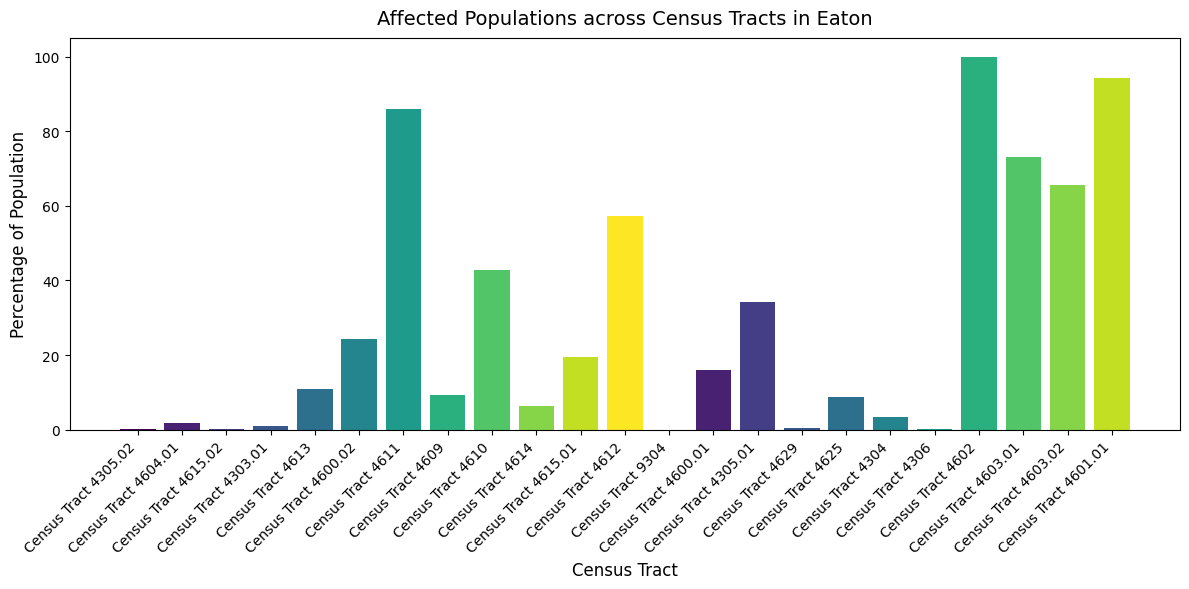

In [88]:
# Generate colors based on the number of census tracts
colors = plt.cm.viridis(np.linspace(0, 1, len(census_tract)))

fig, ax = plt.subplots(figsize=(12, 6))

# Create a bar plot with colors
ax.bar(census_tract_eaton, percent_affected_eaton, color=colors)

# ax.set_xticklabels(census_tract, rotation=45, ha="right", fontsize=10)
plt.xticks(rotation=45, ha="right", fontsize=10)  # This avoids the warning


ax.set_title('Affected Populations across Census Tracts in Eaton', fontsize=14, pad=10)
ax.set_xlabel('Census Tract', fontsize=12)
ax.set_ylabel('Percentage of Population', fontsize=12)

fig.tight_layout()

#### Unique Census Tracts Affected 

In [89]:
unique_tracts_eaton = len(filt_study_area_eaton)

unique_tracts_palisades = len(filt_study_area_palisades)

In [90]:
print("Number of Unique Census Tracts affected by each of the fires:")
print("")
print(f"Eaton: {unique_tracts_eaton}")
print(f"Palisades: {unique_tracts_palisades}")

Number of Unique Census Tracts affected by each of the fires:

Eaton: 23
Palisades: 12


### Findings...
* Significantly more people affected in Palisades in comparison to Eaton 
* More census tracts in Eaton were affected though 
* In general, the tracts and populations affected had a low Social Vulnerability Index and were generally wealthy 